In [2]:
import numpy as np
import scipy.stats as stats

nPaths = 1000

def BS_path(S_0, r, sigma, T, nSteps, drift, nPaths = nPaths):
    """
    Returns [nPaths, nSteps] matrix of nPaths paths of stock price following Black Scholes Model.
    :int T: Number of years the simulation lasts
    """
    delta_i = T/nSteps
    X = np.zeros((nPaths, nSteps+1))      #Create a null matrix of size nPaths, nSteps
    X[:,0] = S_0                          #Set entries on first column to S_0

    for i in range(nSteps):
        #for each step of the simulation, obtain n = nPath normally distributed random numbers
        Z = stats.norm.rvs(size = (nPaths))    
        #add to the result matrix the simulated price at time x + DeltaT according to BS model
        X[:,i+1] = X[:,i]*np.exp((drift-0.5*(sigma**2))*(delta_i)+sigma*np.sqrt(delta_i)*Z)
    return X

def BS(S0, K, T, sigma, r, type, drift):
    """
    S0 = stock price at first day
    K = strike
    T = time in years
    sigma = sigma
    r = risk free rate
    type = call/put
    """
    nSteps = int(np.ceil(T*252)) #Time steps with trading days
    X = BS_path(S0, r, sigma, T, nSteps, drift)

    if type == "puts":
        Price = np.mean(np.exp(-r*T)*np.maximum(0,K-X[:,-1]))
    elif type == "calls":
        Price = np.mean(np.exp(-r*T)*np.maximum(0,X[:,-1]-K))
    else:
        raise Exception("Unexpected input")
    return Price



In [27]:
from datetime import date, timedelta, datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Data

# Set to true to update database from online data, if false will pull data from csv files
Update = False 
trade_days = 365
est_price_path = './Data/est_prices.csv'

#-- Desired interval examined --
start_date = date(2018,11,7)
end_date = datetime.today()
df_end = end_date + timedelta(days=1) #Add one day as yf functions don't include last day
df_end = df_end.date()

# Importing data
df = Data.GetData(start_date, df_end, trade_days, Update)
df = df[df.lastTradeDate >= '2023, 11, 22']
#df = df.sample(1000)  #Reduce data size for testing purposes
r = 0.1

# Uncomment to select only one stock
# stock = '^SPX'
# df = df[df['symbol'] == stock]


LSMC_est_price = [] 
BIN_est_price = [] 
BS_est_price = [] 
MJD_est_price = []
DTR_est_price = []
XGBr_est_price = []
drift = r

# iterates through every option in option chain given a certain stock 
for i in tqdm(range(len(df))):
    S0 = df.iloc[i].S0       # Sets S0
    K = df.iloc[i].strike
    T = df.iloc[i].maturity / 365
    sigma = df.iloc[i].sigma - 0.15
    type = df.iloc[i].optionType
    method = df.iloc[i].method


    if method == 'E':
        computed_price_BS = BS(S0, K, T, sigma, r, type, drift)
    else:
        computed_price_BS = np.nan

    BS_est_price.append(computed_price_BS)

mkt_price = df.lastPrice
BS_perc_error = (mkt_price - BS_est_price)/mkt_price

100%|██████████| 38131/38131 [01:21<00:00, 465.55it/s] 


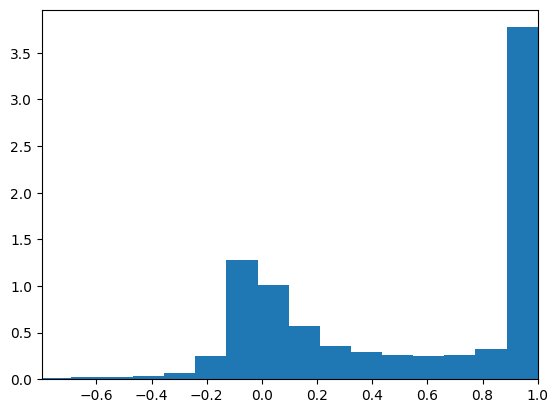

In [32]:
plt.hist(BS_perc_error, bins=2000, density=True)
plt.xlim(np.quantile(BS_perc_error.dropna(),0.01),np.quantile(BS_perc_error.dropna(),0.99))
plt.show()


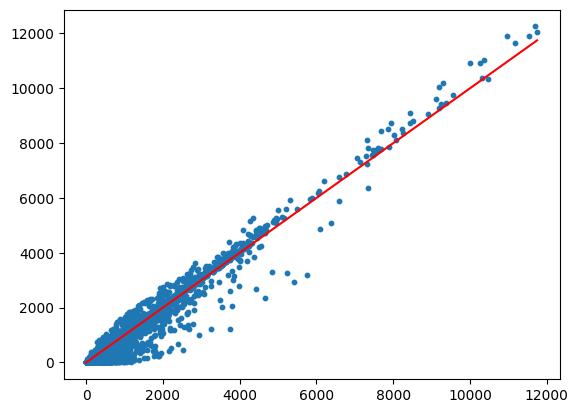

In [29]:
x = np.linspace(min(df.lastPrice), max(df.lastPrice))
plt.scatter(df.lastPrice, BS_est_price, s=10)
plt.plot(x,x, color ='r')